In [1]:
import random
import math
import heapq
import time
import matplotlib.pyplot as plt
from collections import deque, defaultdict

In [2]:
import nbimporter
from graph_utilities import calculer_voisinage_etendu
from graph_utilities import lire_graphe, afficher_graphe, visualiser_graphe_par_etape
from graph_utilities import generate_cyclic_graph, generate_chain_graph, generate_spider_graph

prends en paramètre un graphe dans un état (càd avec des sommets brulés) et retourne le graphe dans l'état suivante

In [3]:
def successeurs(graphe, etat_actuel, cout_actuel):
    """
    Génère l'état suivant en propageant la brûlure aux voisins des sommets déjà brûlés.
    :param graphe: Le graphe sous forme de dictionnaire.
    :param etat_actuel: Dictionnaire contenant l'état actuel des sommets (brûlés ou non brûlés).
    :return: Nouveau dictionnaire représentant l'état des sommets après propagation.
    """

    # Copier l'état actuel pour générer le nouvel état
    nouvel_etat = etat_actuel.copy()

    # Récupérer tous les sommets brûlés
    sommets_brules = [sommet for sommet, etat in nouvel_etat.items() if etat == 1]

    # Propager la brûlure aux voisins des sommets brûlés
    for sommet in sommets_brules:
        for voisin in graphe.get(sommet, []):  # Obtenir les voisins dans la liste d'adjacence
            if nouvel_etat[voisin] == 0:  # Brûler uniquement les sommets non brûlés
                nouvel_etat[voisin] = 1
                cout_actuel += 1  # Incrémenter le coût de propagation

    return nouvel_etat, cout_actuel

test_but : vérifie si tout les sommets sont brulées

In [4]:
def test_but(etat_actuel):
    """
    Vérifie si tous les sommets du graphe sont brûlés.
    :param etat_actuel: Dictionnaire contenant l'état actuel des sommets (brûlés ou non brûlés).
    :return: True si tous les sommets sont brûlés, False sinon.
    """
    return all(etat == 1 for etat in etat_actuel.values())


In [5]:
def choisir_sommet_a_bruler(graphe, etat_actuel):
    """
    Sélectionne un sommet non brûlé ayant le maximum de voisins.
    
    :param graphe: Le graphe sous forme de dictionnaire (liste d'adjacence).
    :param etat_actuel: Dictionnaire contenant l'état actuel des sommets.
    :return: Le sommet non brûlé avec le maximum de voisins, ou None si aucun sommet disponible.
    """
    # Trouver les sommets non brûlés
    sommets_non_brules = [sommet for sommet, etat in etat_actuel.items() if etat == 0]
    
    if not sommets_non_brules:
        # Aucun sommet non brûlé
        return None

    # Trouver le sommet avec le maximum de voisins
    sommet_max_voisins = max(sommets_non_brules, key=lambda sommet: len(graphe.get(sommet, [])))

    return sommet_max_voisins


In [6]:
def choisir_sommet_aleatoire(etat_actuel):
    sommets_non_brules = [sommet for sommet, etat in etat_actuel.items() if etat == 0]
    return random.choice(sommets_non_brules) if sommets_non_brules else None


## 1ère méthode

In [7]:
def recherche_profondeur(graphe):
    """
    Algorithme générique de recherche pour brûler un graphe en choisissant un sommet par étape.
    :param graphe: Le graphe sous forme de dictionnaire (liste d'adjacence).
    :param etat_initial: Dictionnaire représentant l'état initial des sommets (brûlés ou non brûlés).
    :param successeurs: Fonction qui génère l'état suivant (propagation).
    :param test_but: Fonction qui vérifie si tous les sommets sont brûlés.
    :return: Chemin (liste des états successifs), sommets brûlés activement à chaque étape, et coût total.
    """
    # Initialisation : créer la liste des états à traiter
    etat_initial = {sommet: 0 for sommet in graphe}
    etats_a_traiter = deque([{"etat": etat_initial, "cout": 1, "brules_actifs": []}])

    while etats_a_traiter:
        # Extraire un état
        noeud = etats_a_traiter.pop()

        noeud["etat"], brulage = successeurs(graphe, noeud["etat"])

        if brulage:
            noeud["cout"] += 1  # Chaque étape coûte 1

        # Vérifier si tous les sommets sont brûlés
        if test_but(noeud["etat"]):
            return noeud["brules_actifs"], noeud["cout"]

        # Choisir un nouveau sommet à brûler activement
        nouveau_sommet = choisir_sommet_a_bruler(graphe, noeud["etat"])
        #nouveau_sommet = choisir_sommet_aleatoire(noeud["etat"])
        if nouveau_sommet is None:
            # Si aucun sommet à brûler n'est disponible, retourner l'état actuel
            continue

        # Copier l'état courant
        etat_suivant = noeud["etat"].copy()

        # Marquer le sommet comme "brûlé"
        etat_suivant[nouveau_sommet] = 1

        # Ajouter le nouvel état à la liste des états à traiter
        etats_a_traiter.append({
            "etat": etat_suivant,
            "cout": noeud["cout"],  # Chaque étape coûte 1
            "brules_actifs": noeud["brules_actifs"] + [nouveau_sommet]
        })

    # Si aucun état final n'est trouvé
    return [], float("inf")


etape 1 :

parcours en largeur : popleft de la liste des états à traiter

parcours en largeur itéré : livre artificial intelligence section 3.4.4 et 3.4.5


etape 2 : couverture des balles

appliquer le A* dans le parcours

bruler ce noeuds pendant un certain temps
=> couverture par des balles

l'ensemble des action : 
le cout : la taille de la grande balle
fixer burning number dés le début (6)


# 2éme méthode

In [36]:
etat_initial = {sommet: 0 for sommet in graphe}
etats_a_traiter = deque([{"etat": etat_initial, "cout": 1, "brules_actifs": set([])}])
etat = etats_a_traiter.popleft()
list(etat["brules_actifs"] | set([1]))

[1]

In [37]:
def recherche_largeur(graphe):
    """
    Algorithme générique de recherche en largeur pour brûler un graphe.
    À chaque étape, chaque sommet est exploré pour générer tous les états possibles.
    :param graphe: Le graphe sous forme de dictionnaire (liste d'adjacence).
    :param etat_initial: Dictionnaire représentant l'état initial des sommets (brûlés ou non brûlés).
    :param successeurs: Fonction qui génère l'état suivant (propagation).
    :param test_but: Fonction qui vérifie si tous les sommets sont brûlés.
    :return: Chemin (liste des états successifs), sommets brûlés activement à chaque étape, et coût total.
    """
    # Initialisation : file (FIFO) pour gérer les états à traiter
    etat_initial = {sommet: 0 for sommet in graphe}
    etats_a_traiter = deque([{"etat": etat_initial, "cout": 1, "brules_actifs": set([])}])

    while etats_a_traiter:
        # Extraire un état de la file (FIFO)
        etat = etats_a_traiter.popleft()

        # Propager l'état courant (brûlage des voisins déjà brûlés)
        etat["etat"], cout = successeurs(graphe, etat["etat"], etat["cout"])

        # Vérifier si tous les sommets sont brûlés
        if test_but(etat["etat"]):
            return list(etat["brules_actifs"]), etat["cout"]

        # Générer tous les nouveaux états possibles en brûlant chaque sommet non brûlé
        for sommet in graphe:
            if etat["etat"].get(sommet) != 1:  # Si le sommet n'est pas encore brûlé
                # Copier l'état courant
                etat_suivant = etat["etat"].copy()

                # Marquer le sommet comme "brûlé"
                etat_suivant[sommet] = 1

                # Ajouter le nouvel état à la file
                etats_a_traiter.append({
                    "etat": etat_suivant,
                    "cout": cout,
                    "brules_actifs": etat["brules_actifs"] | set([sommet])
                })

    # Si aucun état final n'est trouvé
    return [], float("inf")


In [9]:
# 10 sommets (3.16)
fichier = r'instances\Stranke94\Stranke94.mtx'

# 29 sommets (5.38)
#fichier = r'instances\bn-mouse_visual-cortex_1\bn-mouse_visual-cortex_1.mtx'

# 34 sommets (5,83)
#fichier = r'instances\karate\karate.mtx'

# 62 sommets (7.87)
#fichier = r'instances\dolphins\dolphins.mtx'

# 105 sommets (12.88)
#fichier = r'instances\polbooks\polbooks.mtx'

# 258 sommets (16.06)
#fichier = r'instances\sphere3\sphere3.mtx'

# 379 sommets (19.47)
#fichier = r'instances\ca-netscience\ca-netscience.mtx'

# 7057 sommets (84.005)
#fichier = r'instances\fb-pages-government\fb-pages-government.mtx'

# 11631 sommets (107.84)
#fichier = r'instances\web-wiki-crocodile\web-wiki-crocodile.mtx'

# 196 591 sommets (443.38)
#fichier = r'instances\loc-gowalla_edges\loc-gowalla_edges.mtx'

graphe = lire_graphe(fichier)

In [53]:
# Graphe cyclique (4)
#graphe = generate_cyclic_graph(16)

# Graphe en chaîne (4)
graphe = generate_chain_graph(9)
#graphe = generate_chain_graph(16)

# Graphe en étoile/spider (4.58)
#graphe = generate_spider_graph(0, leg_length=4, num_legs=5)

In [11]:
#sommets_actifs_p, cout = recherche_profondeur(graphe)
#
#print("*********** Parcours en profondeur ***********")
#print("Sommets brûlés à chaque étape:", sommets_actifs_p)
#print("Coût total:", cout)

In [55]:
sommets_actifs_l, cout = recherche_largeur(graphe)

print("*********** Parcours en largeur ***********")
print("Sommets brûlés à chaque étape:", sommets_actifs_l)
print("Coût total:", cout)

*********** Parcours en largeur ***********
Sommets brûlés à chaque étape: [0, 3, 7]
Coût total: 4


dire un sommet va etre brulé au 3 tour par exemple
notre solution (du 2eme algo) sera le  centre (sommet) de la boule ayant le rayon le plus grand

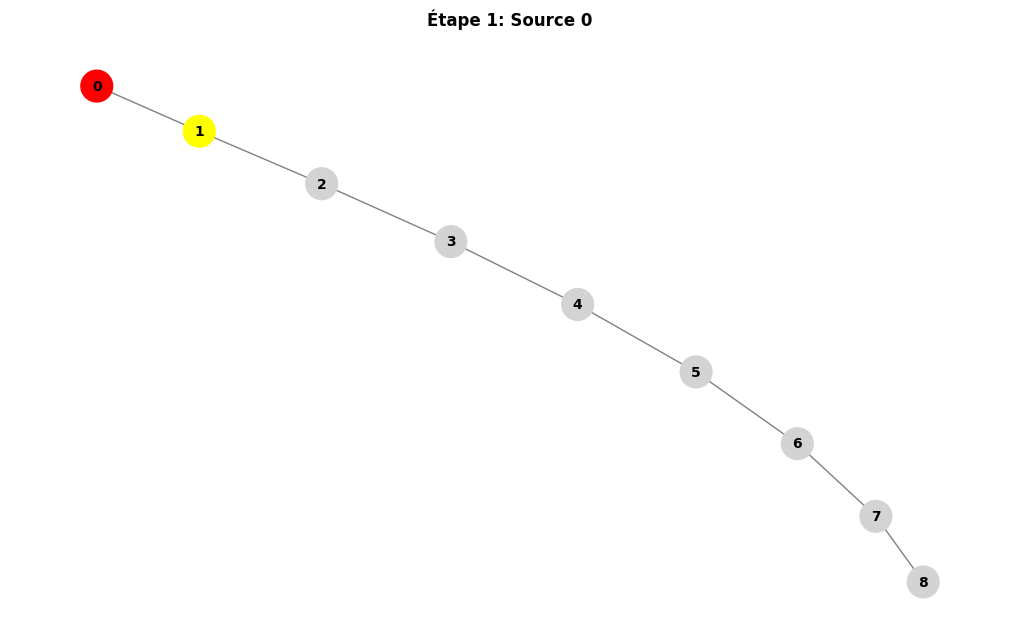

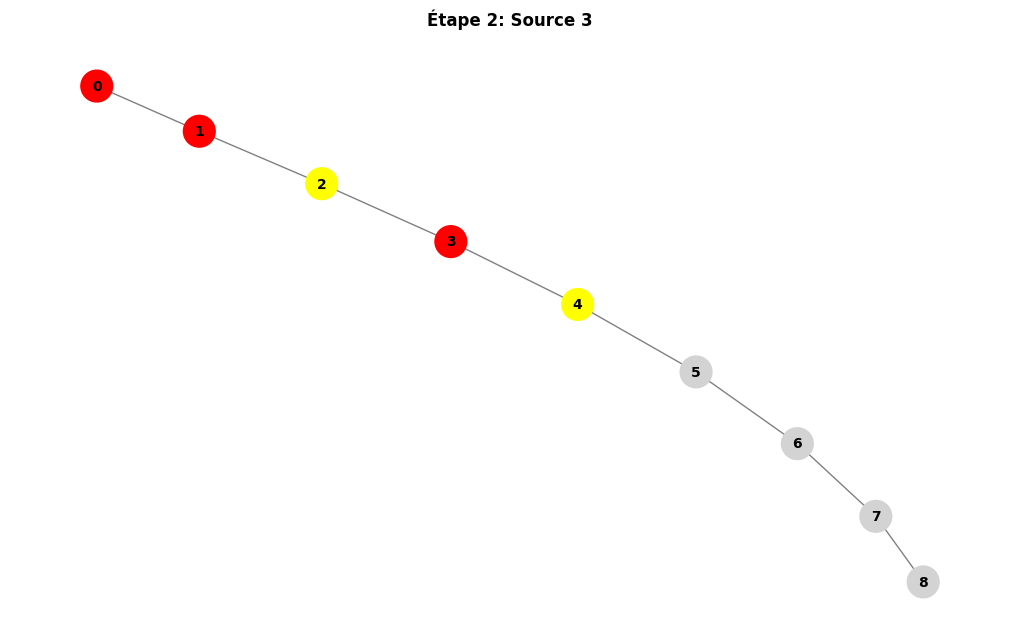

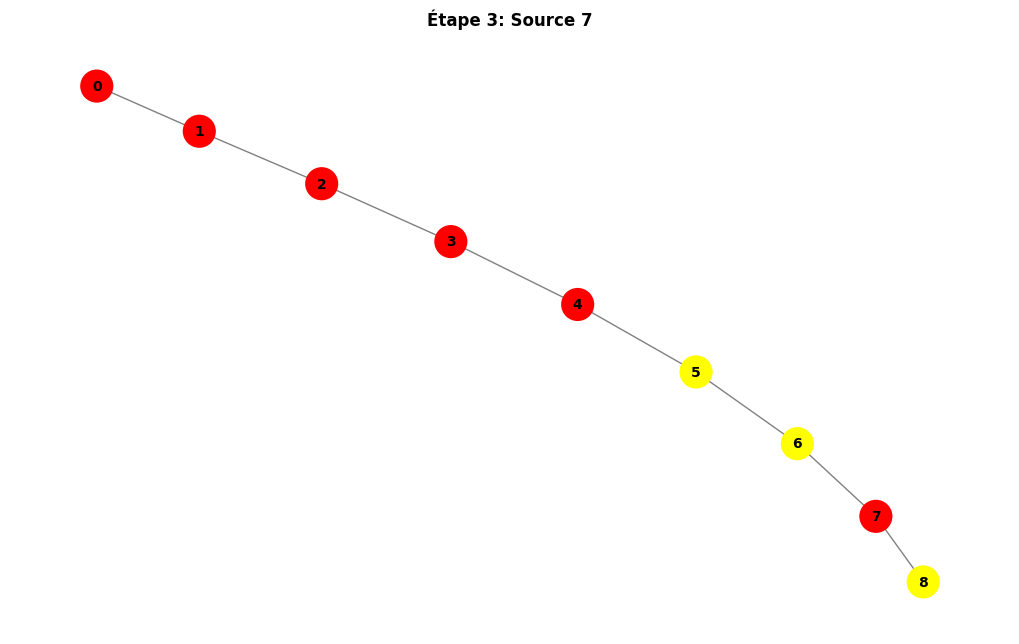

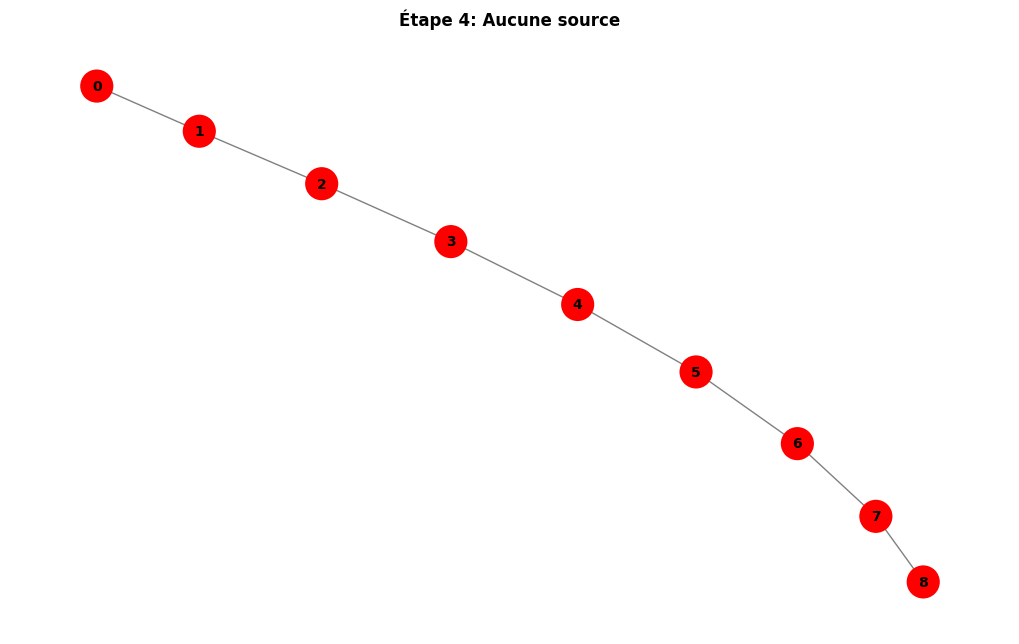

In [56]:
# Visualiser le graphe par étape
visualiser_graphe_par_etape(graphe, sommets_actifs_l)


# Couverture des balles

### Définition clarifiée des balles :
1. **Rayon de la balle** :
   - Le rayon $ r $ détermine combien de niveaux de voisins (profondeur dans le graphe) la balle peut atteindre depuis son centre $ U $.
   - Par exemple :
     - Rayon 1 : Brûle uniquement les voisins directs de $ U $.
     - Rayon 2 : Brûle les voisins de $ U $ et les voisins des voisins de $ U $.

2. **Centre de la balle** :
   - Chaque balle a un centre $ U $, qui est un sommet du graphe. À partir de ce centre, la brûlure se propage jusqu’à une profondeur $ r $.

3. **Objectif** :
   - Trouver un ensemble de balles ($ U_i, r_i $) qui couvrent **tout le graphe**.
   - Chaque sommet du graphe doit être brûlé par au moins une balle.

4. **Contraintes** :
   - Les **rayons des balles doivent être différents**.
   - Toutes les combinaisons possibles de balles (centres et rayons) doivent être explorées pour garantir que le graphe est entièrement couvert.

5. **Propagation de la brûlure** :
   - La propagation de la brûlure à une profondeur $ r $ peut être simulée par un parcours en largeur (BFS) depuis le sommet $ U $, en limitant la profondeur de l’exploration à $ r $.

---

n <- nombre de sommet dans le graphe
r <- math.ceil(math.sqrt(n))
s <- sommet ayant le max de voisins pour commencer

tant que graphe non brulé :
    bruler graphe depuis sommet s avec rayon r
    si tout graphe est brulé :
        retourner (s,r)
    sinon :
        stocker dans la liste (s,r)
        bruler graphe depuis sommet s avec rayon r
        r <- r-1
        sb_base <- calculer nombre sommet non brulé
        pour tout sommet u non brulés :
            bruler graphe depuis u avec rayon r
            sb <- calculer nombre sommet non brulé associé au sommet u
            si tout graphe est brulé :
                r <- r-1
            sinon si sb < sb_base :
                sb_base <- sb
                u_base <- u

In [44]:
def bruler(graphe, u, r):
    """
    Effectue une BFS depuis le sommet u en limitant la profondeur à r.
    Retourne l'ensemble des sommets brûlés (atteints).
    """
    visited = {u}
    queue = deque([(u, 0)])  # (sommet, profondeur)
    while queue:
        current, depth = queue.popleft()
        if depth < r:
            for neighbor in graphe.get(current, []):
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, depth + 1))
    return visited

In [45]:
def couverture_balle(graphe):
    """
    Cherche une séquence de balles (centre, rayon) qui couvre entièrement le graphe.
    
    Contraintes :
      - Les rayons possibles sont 1, 2, ..., ⌈√n⌉ où n = nombre de sommets.
      - Un même rayon ne peut être utilisé qu'une seule fois dans une solution.
      - On explore d'abord les grandes valeurs de rayon (pour potentiellement réduire
        rapidement le nombre de balles et/ou le rayon maximal utilisé).
      
    Retourne la séquence des balles (centre, rayon) de la solution trouvée.
    """

    n = len(graphe)
    V = list(graphe.keys())
    best_sequence = None
    best_max_r = float('inf')
    best_num_balls = float('inf')
    max_rayon_possible = math.ceil(math.sqrt(n))
    #max_rayon_possible = round(math.sqrt(n))
    
    # File de priorité (heap) avec pour chaque état :
    # (heuristique, rayon_max_actuel, nombre_de_balles, sommets_brulés, séquence, rayons_utilisés)
    heap = []
    heapq.heappush(heap, (0, 0, 0, set(), [], set()))
    
    # Dictionnaire de mémorisation pour éviter de revisiter des états moins optimaux
    memo = defaultdict(lambda: (float('inf'), float('inf')))
    
    while heap:
        heur, current_max_r, current_num, brules, seq, used_r = heapq.heappop(heap)
        
        # Élagage : si l'état courant est moins bon que la meilleure solution trouvée, on passe
        # On passe cette branche si l'on sait déjà qu'elle est moins bonne que la meilleure solution trouvée
        if current_max_r > best_max_r or (current_max_r == best_max_r and current_num >= best_num_balls):
            continue
        
        # Si tous les sommets sont brûlés, on met à jour la meilleure solution
        if len(brules) == n:
            if current_max_r < best_max_r or (current_max_r == best_max_r and current_num < best_num_balls):
                best_max_r, best_num_balls, best_sequence = current_max_r, current_num, seq
            continue
        
        # Pour chaque sommet non brûlé, on essaie de l'étendre avec différents rayons
        for v in V:
            if v not in brules:
                # On ne considère pas un rayon supérieur à celui maximum autorisé
                # ni supérieur à best_max_r (pour rester dans une solution potentiellement optimale)
                max_possible_r = min(max_rayon_possible, best_max_r)
                # On explore les grands rayons en premier
                for r in range(max_possible_r - 1, -1, -1): # source de problèèèèèmes
                    # faire un vecteur de rayons utilisés
                    # used_r = [0 for _ in range(max_rayon_possible + 1)]
                    # used_r = [1,1,0,1]
                    if r in used_r:
                        continue  # Ce rayon a déjà été utilisé dans la séquence courante
                    
                    # Calcul à la demande des sommets brûlés par la balle (v, r)
                    burned_with_ball = bruler(graphe, v, r)
                    nouveaux_brules = brules | burned_with_ball
                    new_max_r = max(current_max_r, r)
                    new_num = current_num + 1
                    
                    # Clé pour mémorisation : combinaison des sommets brûlés et des rayons utilisés
                    key = (frozenset(nouveaux_brules), frozenset(used_r | {r}))
                    if (new_max_r, new_num) >= memo[key]:
                        continue
                    memo[key] = (new_max_r, new_num)
                    
                    # Heuristique : rayon maximal utilisé + fraction des sommets restants
                    # l'algorithme donne plus de poids à la minimisation du rayon maximal, mais prend aussi en compte la progression.
                    remaining = n - len(nouveaux_brules)
                    heuristic = new_max_r + (remaining / n)
                    heapq.heappush(heap, (heuristic, new_max_r, new_num, nouveaux_brules, seq + [(v, r)], used_r | {r}))
    
    
    # Optionnel : trier la séquence par rayon décroissant (similaire à la version initiale)
    res = sorted(best_sequence, key=lambda x: x[1], reverse=True)
    res = [(center, rayon + 1) for center, rayon in res]
    return res


In [ ]:
def couverture_balle_zero_un(graphe):
    """
    Cherche une séquence de balles (centre, rayon) qui couvre entièrement le graphe.
    
    Contraintes :
      - Les rayons possibles sont 1, 2, ..., ⌈√n⌉ où n = nombre de sommets.
      - Un même rayon ne peut être utilisé qu'une seule fois dans une solution.
      - On explore d'abord les grandes valeurs de rayon (pour potentiellement réduire
        rapidement le nombre de balles et/ou le rayon maximal utilisé).
      
    Retourne la séquence des balles (centre, rayon) de la solution trouvée.
    """

    n = len(graphe)
    V = list(graphe.keys())
    best_sequence = None
    best_max_r = float('inf')
    best_num_balls = float('inf')
    max_rayon_possible = math.ceil(math.sqrt(n))
    #max_rayon_possible = round(math.sqrt(n))
    
    # File de priorité (heap) avec pour chaque état :
    # (heuristique, rayon_max_actuel, nombre_de_balles, sommets_brulés, séquence, rayons_utilisés)
    heap = []
    initial_used_r = [0] * max_rayon_possible
    heapq.heappush(heap, (0, 0, 0, set(), [], initial_used_r))
    
    # Dictionnaire de mémorisation pour éviter de revisiter des états moins optimaux
    memo = defaultdict(lambda: (float('inf'), float('inf')))
    
    while heap:
        heur, current_max_r, current_num, brules, seq, used_r = heapq.heappop(heap)
        
        # Élagage : si l'état courant est moins bon que la meilleure solution trouvée, on passe
        # On passe cette branche si l'on sait déjà qu'elle est moins bonne que la meilleure solution trouvée
        if current_max_r > best_max_r or (current_max_r == best_max_r and current_num >= best_num_balls):
            continue
        
        # Si tous les sommets sont brûlés, on met à jour la meilleure solution
        if len(brules) == n:
            if current_max_r < best_max_r or (current_max_r == best_max_r and current_num < best_num_balls):
                best_max_r, best_num_balls, best_sequence = current_max_r, current_num, seq
            continue
        
        # Pour chaque sommet non brûlé, on essaie de l'étendre avec différents rayons
        for v in V:
            if v not in brules:
                # On ne considère pas un rayon supérieur à celui maximum autorisé
                # ni supérieur à best_max_r (pour rester dans une solution potentiellement optimale)
                max_possible_r = min(max_rayon_possible, best_max_r)
                # On explore les grands rayons en premier
                for r in range(max_possible_r, 0, -1):
                    if used_r[r-1]:
                        continue  # Ce rayon a déjà été utilisé dans la séquence courante
                    
                    # Calcul à la demande des sommets brûlés par la balle (v, r)
                    burned_with_ball = bruler(graphe, v, r)
                    nouveaux_brules = brules | burned_with_ball
                    new_max_r = max(current_max_r, r)
                    new_num = current_num + 1
                    
                    # Clé pour mémorisation : combinaison des sommets brûlés et des rayons utilisés
                    key = (frozenset(nouveaux_brules), frozenset(used_r | {r}))
                    if (new_max_r, new_num) >= memo[key]:
                        continue
                    memo[key] = (new_max_r, new_num)
                    
                    # Heuristique : rayon maximal utilisé + fraction des sommets restants
                    # l'algorithme donne plus de poids à la minimisation du rayon maximal, mais prend aussi en compte la progression.
                    remaining = n - len(nouveaux_brules)
                    heuristic = new_max_r + (remaining / n)
                    heapq.heappush(heap, (heuristic, new_max_r, new_num, nouveaux_brules, seq + [(v, r)], used_r | {r}))
    
    
    # Optionnel : trier la séquence par rayon décroissant (similaire à la version initiale)
    res = sorted(best_sequence, key=lambda x: x[1], reverse=True)
    res = [(center, rayon + 1) for center, rayon in res]
    return res


In [54]:
sequence_opt = couverture_balle(graphe)
cout_bb = max([rayon for centre, rayon in sequence_opt])

sequence_opt

[(6, 3), (2, 2), (0, 1)]

In [ ]:
visualiser_graphe_par_etape(graphe, [centre for centre, rayon in df.iloc[num]["Couverture des balles"]])


In [ ]:
def couverture_balle_timing(graphe):
    """
    Retourne la séquence finale (liste des couples (sommet, rayon+1)) et
    une liste 'time_data' contenant tous les états candidats rencontrés durant l'exécution.
    
    Chaque enregistrement de 'time_data' est un tuple composé de :
      - Le temps (en secondes) écoulé depuis le début.
      - Le rayon maximum (current_max_r) pour cet état.
      - Le sommet actuellement utilisé (source de feu) pour cet état.
      - La séquence complète des coups (c'est-à-dire la liste des (sommet, rayon)) jusqu'à cet état.
    """
    start_time = time.time()
    time_data = []  # on va y enregistrer tous les états candidats
    n = len(graphe)
    V = list(graphe.keys())
    
    best_sequence = None
    best_max_r = float('inf')
    best_num_balls = float('inf')
    max_rayon_possible = math.ceil(math.sqrt(n))
    
    # Initialisation de la file de priorité.
    # Chaque élément est un tuple : (heuristique, current_max_r, current_num, brules, seq, used_r)
    heap = []
    heapq.heappush(heap, (0, 0, 0, set(), [], set()))
    memo = defaultdict(lambda: (float('inf'), float('inf')))
    
    while heap:
        heur, current_max_r, current_num, brules, seq, used_r = heapq.heappop(heap)
        current_time = time.time() - start_time
        
        # Enregistrement de l'état courant (celui que l'on vient de dépiler) :
        current_state_vertex = seq[-1][0] if seq else None
        time_data.append((current_time, current_max_r, current_state_vertex))
        
        # On abandonne cette branche si on sait déjà qu'elle est moins bonne que la meilleure solution connue.
        if current_max_r > best_max_r or (current_max_r == best_max_r and current_num >= best_num_balls):
            continue
        
        # Si l'état courant correspond à une solution complète (tous les sommets brûlés),
        # on met à jour la solution optimale (mais on continue d'enregistrer l'état)
        if len(brules) == n:
            if current_max_r < best_max_r or (current_max_r == best_max_r and current_num < best_num_balls):
                best_max_r, best_num_balls, best_sequence = current_max_r, current_num, seq
            # Même si c'est une solution complète, on continue l'exploration (pour enregistrer tous les états)
            continue
        
        # Exploration des prochaines possibilités
        for v in V:
            if v not in brules:
                max_possible_r = min(max_rayon_possible, best_max_r)
                for r in range(max_possible_r - 1, -1, -1):
                    if r in used_r:
                        continue

                    burned_with_ball = bruler(graphe, v, r)  # Assurez-vous que 'bruler' est définie et retourne un ensemble de sommets
                    nouveaux_brules = brules | burned_with_ball
                    new_max_r = max(current_max_r, r)
                    new_num = current_num + 1

                    key = (frozenset(nouveaux_brules), frozenset(used_r | {r}))
                    
                    if (new_max_r, new_num) >= memo[key]:
                        continue
                    memo[key] = (new_max_r, new_num)
                    
                    # Enregistrement de l'état candidat généré juste avant de l'ajouter à la file
                    candidate_time = time.time() - start_time
                    candidate_seq = seq + [(v, r)]
                    time_data.append((candidate_time, new_max_r, v))
                    
                    remaining = n - len(nouveaux_brules)
                    heuristic = new_max_r + (remaining / n)
                    heapq.heappush(heap, (heuristic, new_max_r, new_num, nouveaux_brules, candidate_seq, used_r | {r}))
    
    final_time = time.time() - start_time
    # Enregistrement final de l'état optimal (s'il existe)
    final_vertex = best_sequence[-1][0] if best_sequence and len(best_sequence) > 0 else None
    time_data.append((final_time, best_max_r, final_vertex))
    
    if best_sequence is None:
        return [], time_data
    
    # On retourne la séquence finale (en ajustant le rayon si nécessaire) et tous les enregistrements.
    res = [(center, rayon + 1) for center, rayon in best_sequence]
    return res, time_data


In [ ]:
centres_rayons, time_data = couverture_balle_timing(graphe)
#cout_bb = max([rayon for centre, rayon in sequence_opt])

centres_rayons

In [ ]:
sequence = [centre for centre, rayon in centres_rayons]
data = [(t, burning, balles) for t, burning, balles in time_data if balles in sequence]

plt.figure(figsize=(20, 5))

for centre in set(balles for _, _, balles in data):
    plt.plot(
        [t for t, burning, balles in data if balles == centre],
        [burning for t, burning, balles in data if balles == centre],
        label=f"Ballon {centre}"
    )

plt.xlabel("Temps d'exécution (s)")
plt.ylabel("Burning number")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Création d'un dictionnaire pour regrouper les données par "balles"
grouped_data = {}
for t, burning, balles, l in time_data:
    if (balles not in grouped_data):
        grouped_data[balles] = {'time': [], 'burning': []}
    grouped_data[balles]['time'].append(t)
    grouped_data[balles]['burning'].append(burning)

# Tracé des courbes pour chaque groupe
plt.figure(figsize=(12, 6))
for balles, data in grouped_data.items():
    plt.plot(data['time'], data['burning'], 'o-', label=f"Balles : {balles}")

plt.xlabel("Temps d'exécution (s)")
plt.ylabel("Burning number")
plt.legend()
plt.grid(True)
plt.show()

- imposer un limite de 10s -> faire la recherche pendant max 10s
- tester pour diff periode de temps, arreter après avoir passer cette periode de temps, et voir au bout de quel moment arrive à un solution optimale (ou meme comparer la qté de a solution)

=> figure : 
- x : periode d'exec
- y : burning number
- clé : diff graphe


(HPC serveur frontal de l'isima => faire assez de calcule en paralelle qu'on veux)

- bruler le graphe à un certain rayon et calculer ça connectivité 
- calculer le nbr de composant connexe ( à chercher ça def)
- diametre = le nbr de sommet entre les deux sommet les plus éloigné du graphe

objectif : relaxation linéaire pour les petits graphes

In [ ]:
visualiser_graphe_par_etape(graphe, [3, 9, 13, 15])